## Loan defaulters prediction

In [1]:
# import the modules
import numpy as np
import pandas as pd
import collections
#Stat and math
from math import sqrt
from scipy.stats import norm,skew

import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Data Processing 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

#Impute
from sklearn.impute import SimpleImputer

#Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


#Linear
from sklearn.linear_model import LinearRegression, Lasso, Ridge
#Logistic
from sklearn.linear_model import LogisticRegression
#Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

# Evaluation metric
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score



### Load the dataset


In [2]:
# Train dataset
Train = pd.read_csv('train.csv')
# Test dataset
Test = pd.read_csv('test.csv')
# Shape of data
print(Train.shape)
# First 5 rows from dataframe
Train.head(5)


(7662, 16)


,Id,customer.id,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,pub.rec,inq.last.6mths,delinq.2yrs,paid.back.loan
0,6269,LA006270,Yes,debt_consolidation,12.53%,689.41,11.513725,14.45,722,4291.000000,13171,51.8,0,Less than 5,No,Yes
1,1460,LA001461,Yes,credit_card,10.20%,485.42,10.315597,12.87,752,5789.958333,14857,31.3,0,Less than 5,Yes,Yes
2,5539,LA005540,Yes,debt_consolidation,12.87%,121.08,11.238436,1.58,692,3391.000000,12135,85.5,0,Less than 5,No,Yes
3,9020,LA009021,No,all_other,15.37%,348.47,11.142007,11.01,687,5370.000000,10631,35.3,0,Less than 10,No,Yes
4,4365,LA004366,Yes,debt_consolidation,14.61%,344.76,10.308953,11.36,672,2429.958333,10544,57.0,0,Less than 5,Yes,Yes


In [4]:
# Drop Id column from train and test data
train=Train.drop(columns={'Id','customer.id'})
test=Test.drop(columns={'Id','customer.id'})
print('train:',train.shape)
print('test:',test.shape)

train: (7662, 14)
test: (1916, 13)


In [5]:
# Chech null value and datatype of train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      7662 non-null   object 
 1   purpose            7662 non-null   object 
 2   int.rate           7662 non-null   object 
 3   installment        7662 non-null   float64
 4   log.annual.inc     7662 non-null   float64
 5   dti                7662 non-null   float64
 6   fico               7662 non-null   int64  
 7   days.with.cr.line  7662 non-null   float64
 8   revol.bal          7662 non-null   int64  
 9   revol.util         7662 non-null   float64
 10  pub.rec            7662 non-null   int64  
 11  inq.last.6mths     7662 non-null   object 
 12  delinq.2yrs        7662 non-null   object 
 13  paid.back.loan     7662 non-null   object 
dtypes: float64(5), int64(3), object(6)
memory usage: 838.2+ KB


In [6]:
# Statistics for train data
train.describe()

,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,pub.rec
count,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000
mean,318.073414,10.927664,12.628104,710.626990,4556.132167,16801.462151,46.674093,0.061342
std,207.121270,0.619736,6.856764,37.919831,2492.455086,32315.194429,28.956386,0.260323
min,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000,0.000000,0.000000
25%,163.570000,10.545447,7.212500,682.000000,2819.958333,3163.250000,22.600000,0.000000
50%,267.735000,10.925938,12.705000,707.000000,4113.520834,8538.500000,46.000000,0.000000
75%,430.910000,11.289782,17.940000,737.000000,5739.239583,18144.250000,70.700000,0.000000
max,940.140000,14.528354,29.960000,827.000000,17616.000000,952013.000000,119.000000,5.000000


In [7]:
# Data cleaning for train and test set
train['int.rate'] = train['int.rate'].str.replace('%', '')
test['int.rate'] = test['int.rate'].str.replace('%', '')
train = train.astype({"int.rate": float})
test = test.astype({"int.rate": float})

In [8]:
# chech unique value purpose column
train.purpose.unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

### Encoding Yes=1 No=0

In [182]:
train.loc[train['paid.back.loan']=='Yes', 'paid.back.loan'] = 1
train.loc[train['paid.back.loan']=='No', 'paid.back.loan'] = 0

train.loc[train['credit.policy']=='Yes', 'credit.policy'] = 1
train.loc[train['credit.policy']=='No', 'credit.policy'] = 0

train.loc[train['delinq.2yrs']=='Yes', 'delinq.2yrs'] = 1
train.loc[train['delinq.2yrs']=='No', 'delinq.2yrs'] = 0

test.loc[test['credit.policy']=='Yes', 'credit.policy'] = 1
test.loc[test['credit.policy']=='No', 'credit.policy'] = 0

test.loc[test['delinq.2yrs']=='Yes', 'delinq.2yrs'] = 1
test.loc[test['delinq.2yrs']=='No', 'delinq.2yrs'] = 0


## Visualize the data


In [12]:
### Catagorical and numerical column

cat_col = [col for col in train.columns 
                       if train[col].dtype.name == 'object']
num_col = [col for col in train.columns 
                     if train[col].dtype.name != 'object']

print('categorical_columns:', cat_col)
print('numerical_columns:', num_col)

categorical_columns: ['credit.policy', 'purpose', 'inq.last.6mths', 'delinq.2yrs', 'paid.back.loan']
numerical_columns: ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'pub.rec']


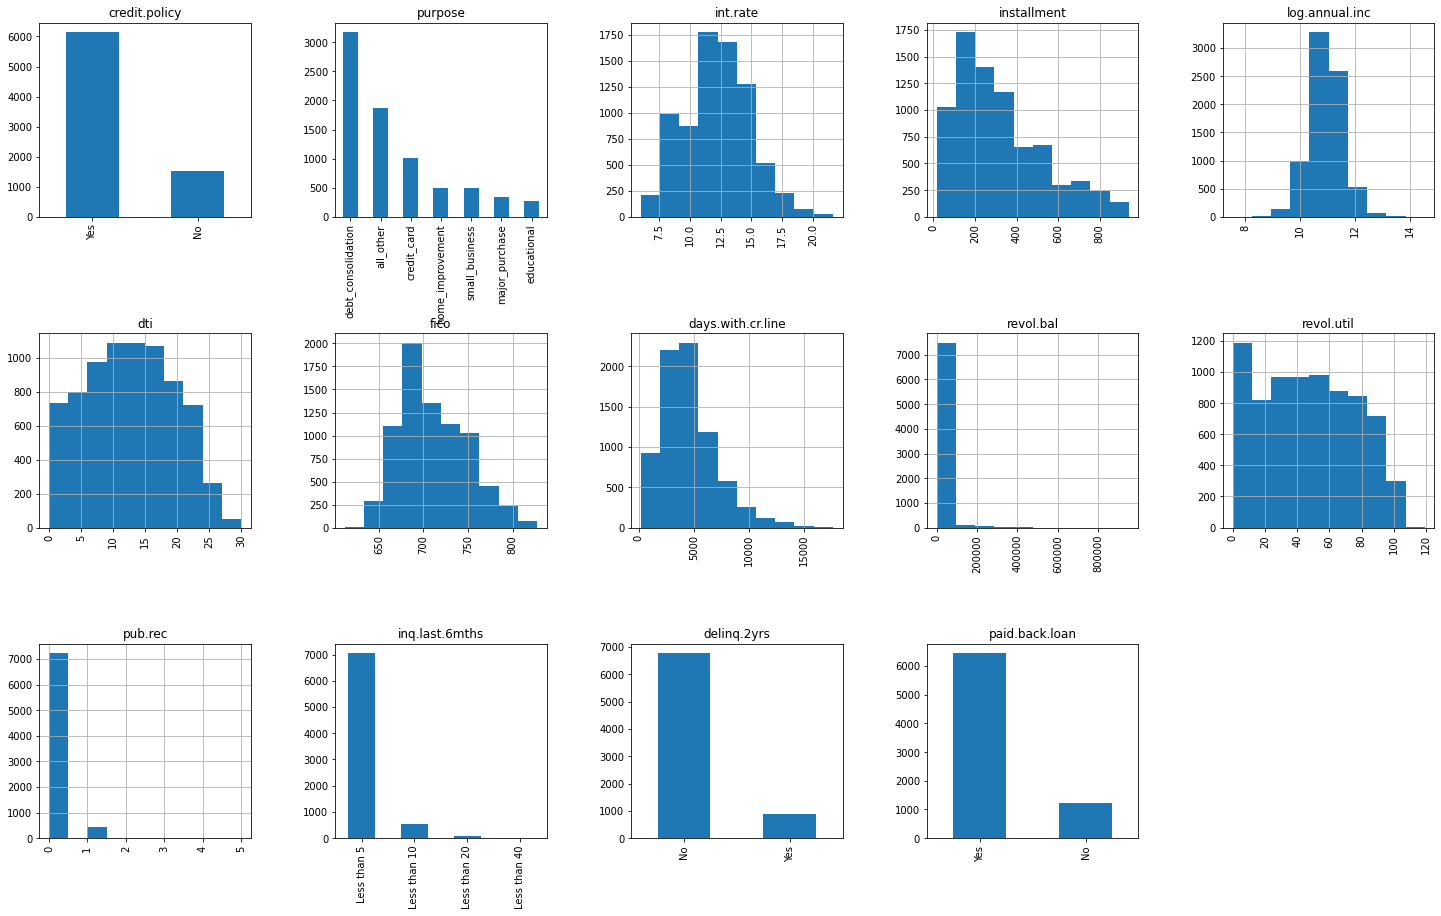

In [13]:
# Distribution plot of train data

fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(train.shape[1]) / cols)
for i, column in enumerate(train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if train.dtypes[column] == np.object:
        train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.6, wspace=0.4)

In [14]:
# Label encoding for categorical column
le = LabelEncoder()

for x in cat_col:
    train[x] = le.fit_transform(train[x])
    if x in [c for c in test.columns 
                       if test[c].dtype.name == 'object']:
        test[x] = le.transform(test[x])
      

In [16]:
# print new label for inq.last.6mths column
train['inq.last.6mths'].unique()

array([3, 0, 2, 1])

### Model building

In [17]:
# Separate the features and target.
X = train.iloc[:, :-1]
y = train.iloc[:, -1]
# Split train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=0)

In [188]:
# Initialize decision tree model
dt = DecisionTreeClassifier(max_depth=3, random_state=0)
# Fit the model
dt.fit(X_train, y_train)
# Predict the model
dt_predictions = dt.predict(X_val) 
# print accuracy of the model
print("Decision tree accuracy: ",accuracy_score(y_val,dt_predictions))

Decision tree accuracy:  0.8351457155284906


In [189]:
# parameter tunning
tree_params = {'max_depth': range(2,15)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=0),
                                 tree_params, cv=5)                  


locally_best_tree.fit(X_train, y_train)

print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 2}
Best cross validaton score 0.8402011378336649


In [190]:
dt_tune = DecisionTreeClassifier(max_depth=2, random_state=0)
dt_tune.fit(X_train, y_train)
dt_tune_predictions = dt_tune.predict(X_val)
print("Auracy after tuning: ",accuracy_score(y_val, dt_tune_predictions))

Auracy after tuning:  0.8412353197042193


### Prediction on the test data and creating the sample submission file.


In [193]:
# Storing the id from the test file
id_ = Test['Id']

# Predict on the test data
y_pred_test = dt_tune.predict(test)

# Create a sample submission file
final_submission = pd.DataFrame({'Id':id_,'paid.back.loan':y_pred_test})

final_submission.loc[final_submission['paid.back.loan']==1, 'paid.back.loan'] = 'Yes'
final_submission.loc[final_submission['paid.back.loan']==0, 'paid.back.loan'] = 'No'

# Convert the sample submission file into a csv file
final_submission.to_csv('final_submission.csv',index=False)



# Code ends here

In [194]:
final_submission

,Id,paid.back.loan
0,5468,Yes
1,7530,Yes
2,501,Yes
3,2690,Yes
4,3691,Yes
...,...,...
1911,1912,Yes
1912,8342,Yes
1913,7898,Yes
1914,4288,Yes


In [ ]:
#End